Author: Carlos Roberto de Melo

Date: 06/01/2020

Obj:
1. Cortar as imagens originais.
2. Fazer uso do código aberto Astroalign para remover qualquer tipo de offset entre as diferentes bandas.
3. Centralizar as imagens já registradas e manter apenas a galáxia no produto final.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from mpdaf.obj import Image, WCS
from mpdaf.obj import deg2sexa, sexa2deg

Os blocos abaixos se destinam a realizar um corte ao redor da galáxia de interesse, mas deixando alguns estrelas e/ou globulares, de modo que possam ser utilizados como referência para um possível ajuste de offset que será feito adiante. Posteriormente após o ajuste de offset ser feito, iremos recortar novamente as imagens de modo que reste apenas a galáxia de interesse na imagem final.

In [33]:
#Abre as imagens originais .fits
f814w = Image('/home/carlos/Documents/Dados Projeto/ESO325/HubbleMosaic/hst_mos_0032511_acs_wfc_f814w_drz.fits')
f475w = Image('/home/carlos/Documents/Dados Projeto/ESO325/HubbleMosaic/hst_mos_0032511_acs_wfc_f475w_drz.fits')

In [34]:
#Mostra as informações relevantes de cada imagem
f814w.info()
f475w.info()

[INFO] 7400 x 8000 Image (/home/carlos/Documents/Dados Projeto/ESO325/HubbleMosaic/hst_mos_0032511_acs_wfc_f814w_drz.fits)
[INFO] .data(7400 x 8000) (no unit), no noise
[INFO] center:(-38:11:00.9,13:43:34.5437) size:(296.000",320.000") step:(0.040",0.040") rot:-0.0 deg frame:FK5
[INFO] 7400 x 8000 Image (/home/carlos/Documents/Dados Projeto/ESO325/HubbleMosaic/hst_mos_0032511_acs_wfc_f475w_drz.fits)
[INFO] .data(7400 x 8000) (no unit), no noise
[INFO] center:(-38:11:00.9,13:43:34.5437) size:(296.000",320.000") step:(0.040",0.040") rot:0.0 deg frame:FK5


In [35]:
#Define o centro onde será feito o corte. Neste caso estamos usando os valores presentes
# em Collet et al 2018
RA = '13:43:33.2'
DEC = '−38:10:34'
center_sexa = (DEC,RA)
center_deg = sexa2deg(center_sexa) #Converte sexagessimal para graus
center_deg

array([-38.1761, 205.888 ])

**center**: centro onde será feito po corte. Formato é (y,x) = (DEC,RA)

**unit_center**: unidades do centro, em astropy units. Se valor for None, então é assumido px

**size**: tamanho do corte, em astropy units

**unit_size**: unidades do tamanho d corte, em astropy units. Se o valor for None, então é assumido px

In [36]:
corte_f814 = f814w.subimage(center=center_deg, unit_center=u.deg,size=50,unit_size=u.arcsec)
corte_f475 = f475w.subimage(center=center_deg, unit_center=u.deg,size=50,unit_size=u.arcsec)

[INFO] 1250 x 1250 Image (/home/carlos/Desktop/ESO325 HST Data Reduction/Data/Corte_F814w_30arcsec.fits)
[INFO] .data(1250 x 1250) (no unit), no noise
[INFO] center:(-38:10:33.9794,13:43:33.1189) size:(50.000",50.000") step:(0.040",0.040") rot:-0.0 deg frame:FK5
[INFO] 1250 x 1250 Image (/home/carlos/Desktop/ESO325 HST Data Reduction/Data/Corte_F475w_30arcsec.fits)
[INFO] .data(1250 x 1250) (no unit), no noise
[INFO] center:(-38:10:33.9794,13:43:33.1189) size:(50.000",50.000") step:(0.040",0.040") rot:0.0 deg frame:FK5


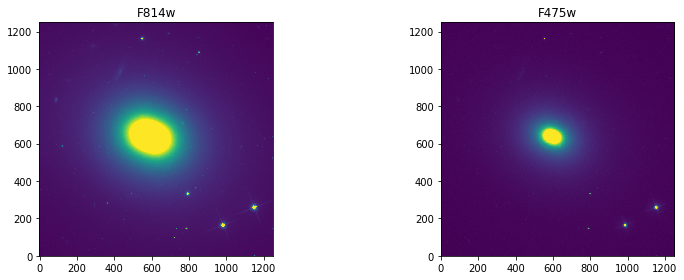

In [40]:
#Plota imagem do corte
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

corte_f814.plot(ax=ax1, vmin=0, vmax=1, title='F814w')
corte_f475.plot(ax=ax2, vmin=0, vmax=1, title='F475w')


corte_f814.info()
corte_f475.info()

corte_f814.write('/home/carlos/Desktop/ESO325 HST Data Reduction/Data/Corte_F814w_50arcsec.fits') #Salva o corte
corte_f475.write('/home/carlos/Desktop/ESO325 HST Data Reduction/Data/Corte_F475w_50arcsec.fits')

Os próximos blocos farão uso das imagens recortadas acima para buscar (e eventualemente corrigir) offsets. Isso é feito pelo código aberto **Astroaligns** disponível em https://astroalign.readthedocs.io/en/latest/

In [41]:
import astroalign as aa
import pandas as pd
from astropy.io import fits

In [42]:
f814w = fits.open('/home/carlos/Desktop/ESO325 HST Data Reduction/Data/Corte_F814w_50arcsec.fits') #Abre a imagem .fits
f814_data = f814w[1].data #Coleta os dados
f814_header = f814w[1].header #Abre o header
f814_data = f814_data.byteswap().newbyteorder() #Necessário por conpatibilidade 32/64 bits

f475w = fits.open('/home/carlos/Desktop/ESO325 HST Data Reduction/Data/Corte_F475w_50arcsec.fits')
f475_data = f475w[1].data
f475_header = f475w[1].header
f475_data = f475_data.byteswap().newbyteorder()

In [43]:
#Realiza o registro com o astroalign/Solve registration with astroalign
#Aqui estamos usando a imagem f814w como referência para a imagem f475w
f475w_aligned, footprint = aa.register(f475_data, f814_data)

#Printa a informação com os pontos usados para realizar o registro
p, (pos_img, pos_img_rot) = aa.find_transform(f475_data, f814_data)
print("Rotation: {:.2f} degrees".format(p.rotation * 180.0 / np.pi))
print("\nScale factor: {:.2f}".format(p.scale))
print("\nTranslation: (x, y) = ({:.2f}, {:.2f})".format(*p.translation))
print("\nTranformation matrix:\n{}".format(p.params))
print("\nPoint correspondence:")
for (x1, y1), (x2, y2) in zip(pos_img, pos_img_rot):
    print("({:.2f}, {:.2f}) in source --> ({:.2f}, {:.2f}) in target"
          .format(x1, y1, x2, y2))

Rotation: -0.01 degrees

Scale factor: 1.00

Translation: (x, y) = (-0.38, 0.20)

Tranformation matrix:
[[ 9.99932745e-01  1.01713356e-04 -3.82021454e-01]
 [-1.01713356e-04  9.99932745e-01  1.96500825e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Point correspondence:
(790.49, 147.76) in source --> (790.04, 147.91) in target
(366.48, 282.45) in source --> (366.21, 282.55) in target
(54.66, 1085.59) in source --> (54.46, 1085.72) in target
(55.32, 970.18) in source --> (54.95, 970.37) in target
(124.07, 587.31) in source --> (123.76, 587.37) in target
(854.80, 1088.54) in source --> (854.49, 1088.77) in target
(1248.08, 145.67) in source --> (1247.93, 145.76) in target
(486.51, 86.05) in source --> (486.27, 86.19) in target
(755.71, 350.71) in source --> (755.46, 350.86) in target
(692.66, 1188.47) in source --> (692.11, 1188.52) in target
(983.53, 164.45) in source --> (982.75, 164.57) in target
(837.73, 363.89) in source --> (837.30, 363.20) in target
(1149.70, 259.55) in 

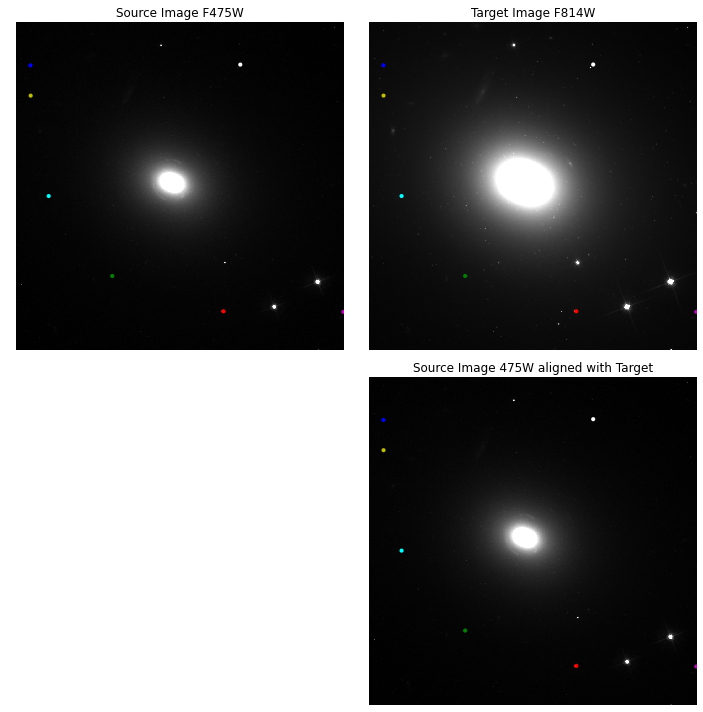

In [44]:
#Plota as imagens antes e depois do registro, além de marcar quais pontos foram usados para tal

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

colors = ['r', 'g', 'b', 'y', 'cyan', 'w', 'm']

axes[0, 0].imshow(f475_data, cmap='gray', interpolation='none', origin='lower', vmin=0,vmax=1)
axes[0, 0].axis('off')
axes[0, 0].set_title("Source Image F475W")
for (xp, yp), c in zip(pos_img[:len(colors)], colors):
    circ = plt.Circle((xp, yp), 4, fill=False, edgecolor=c, linewidth=2)
    axes[0, 0].add_patch(circ)

axes[0, 1].imshow(f814_data, cmap='gray', interpolation='none', origin='lower',vmin=0, vmax=1)
axes[0, 1].axis('off')
axes[0, 1].set_title("Target Image F814W")
for (xp, yp), c in zip(pos_img_rot[:len(colors)], colors):
    circ = plt.Circle((xp, yp), 4 * p.scale, fill=False, edgecolor=c, linewidth=2)
    axes[0, 1].add_patch(circ)

axes[1, 1].imshow(f475w_aligned, cmap='gray', interpolation='none', origin='lower',vmin=0, vmax=1)
axes[1, 1].axis('off')
axes[1, 1].set_title("Source Image 475W aligned with Target")
for (xp, yp), c in zip(pos_img_rot[:len(colors)], colors):
    circ = plt.Circle((xp, yp), 4 * p.scale, fill=False, edgecolor=c, linewidth=2)
    axes[1, 1].add_patch(circ)

axes[1, 0].axis('off')
plt.tight_layout()
plt.show()

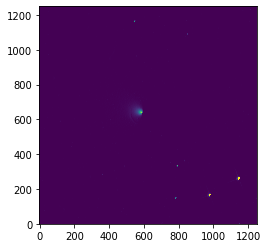

In [45]:
#salvando a imagem F475w alinhada com a F814w
header_new = f475_header
new = fits.PrimaryHDU(f475w_aligned,header=header_new)
hdul = fits.HDUList([new])
hdul.writeto('/home/carlos/Desktop/ESO325 HST Data Reduction/Data/Corte_F475w_50arcsec_align.fits')

#Plotando a diferença entre a imagem F475w registrada e a original. Depois disso salvamos essa imagem
plt.imshow(f475w_aligned - f475_data, vmin=0, vmax=0.1,origin='lower')
plt.savefig('/home/carlos/Desktop/ESO325 HST Data Reduction/Images/F475w_diference.png', fmt='png',dpi=1200)

Após realizar o registro entre as imagens, finalmente podemos realizar o corte final, com o objetivo de mantermos apenas a galáxia em nossa imagem

In [46]:
#Abrindo as imagens cortadas e alinhadas
F814W = Image('/home/carlos/Desktop/ESO325 HST Data Reduction/Data/Corte_F814w_50arcsec.fits') #Open the image file F814w
F475W = Image('/home/carlos/Desktop/ESO325 HST Data Reduction/Data/Corte_F475w_50arcsec_align.fits') #Open the image file F475w
F814W.info() #Display information about the file
F475W.info() #Display information about the file

[INFO] 1250 x 1250 Image (/home/carlos/Desktop/ESO325 HST Data Reduction/Data/Corte_F814w_50arcsec.fits)
[INFO] .data(1250 x 1250) (no unit), no noise
[INFO] center:(-38:10:33.9794,13:43:33.1189) size:(50.000",50.000") step:(0.040",0.040") rot:-0.0 deg frame:FK5
[INFO] 1250 x 1250 Image (/home/carlos/Desktop/ESO325 HST Data Reduction/Data/Corte_F475w_50arcsec_align.fits)
[INFO] .data(1250 x 1250) (no unit), no noise
[INFO] center:(-38:10:33.9794,13:43:33.1189) size:(50.000",50.000") step:(0.040",0.040") rot:0.0 deg frame:FK5


In [47]:
#Cortando as imagens ao redor do pixel central definido pelo MGE das imagens anteriores
MGE_CentralPx = (638,594) #Central pixel found by MGE. The format is (y,x)

F814W_centerized = F814W.subimage(center=MGE_CentralPx, unit_center=None, size=30., unit_size=u.arcsec)
F475W_centerized = F475W.subimage(center=MGE_CentralPx, unit_center=None, size=30., unit_size=u.arcsec)

#Salvando os novos cortes
F814W_centerized.write('/home/carlos/Desktop/ESO325 HST Data Reduction/Data/F814W_centerized.fits') #Save the new centralized images
F475W_centerized.write('/home/carlos/Desktop/ESO325 HST Data Reduction/Data/F475W_centerized.fits')

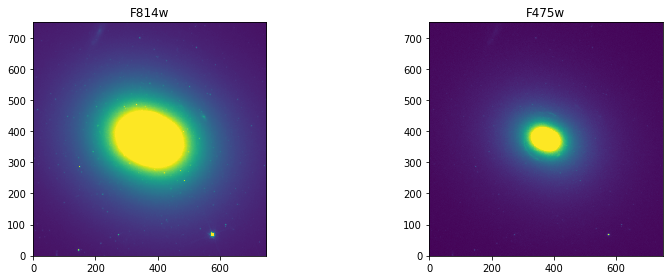

In [48]:
#Plotando os novos cortes
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

F814W_centerized.plot(ax=ax1, vmin=0, vmax=1, title='F814w')
F475W_centerized.plot(ax=ax2, vmin=0, vmax=1, title='F475w')